<a href="https://colab.research.google.com/github/gabrielaaltnv/pli/blob/main/finalassignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

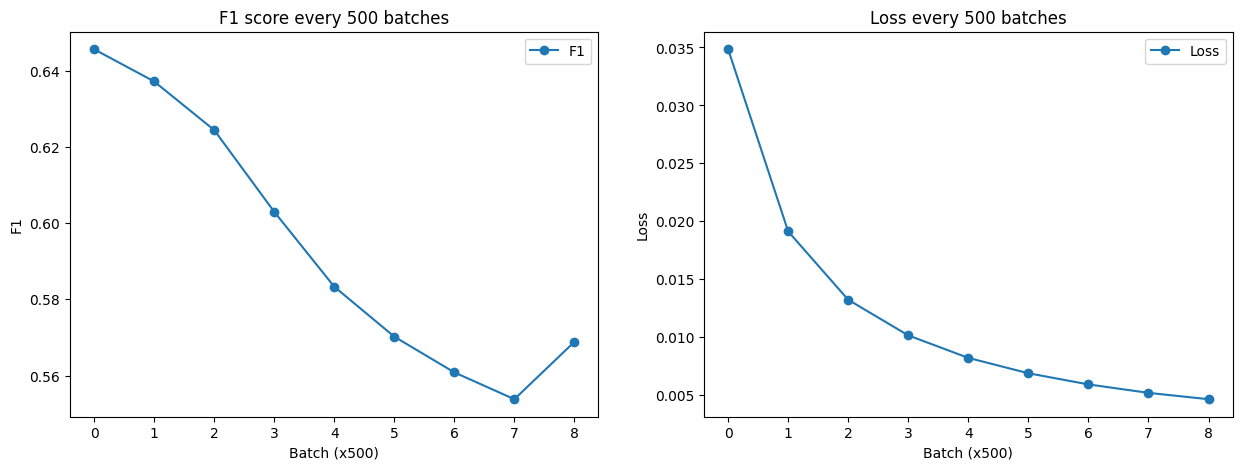

Loss: 0.0044 | F1: 0.5768:  10%|▉         | 4753/50000 [05:10<49:14, 15.32it/s]


KeyboardInterrupt: 

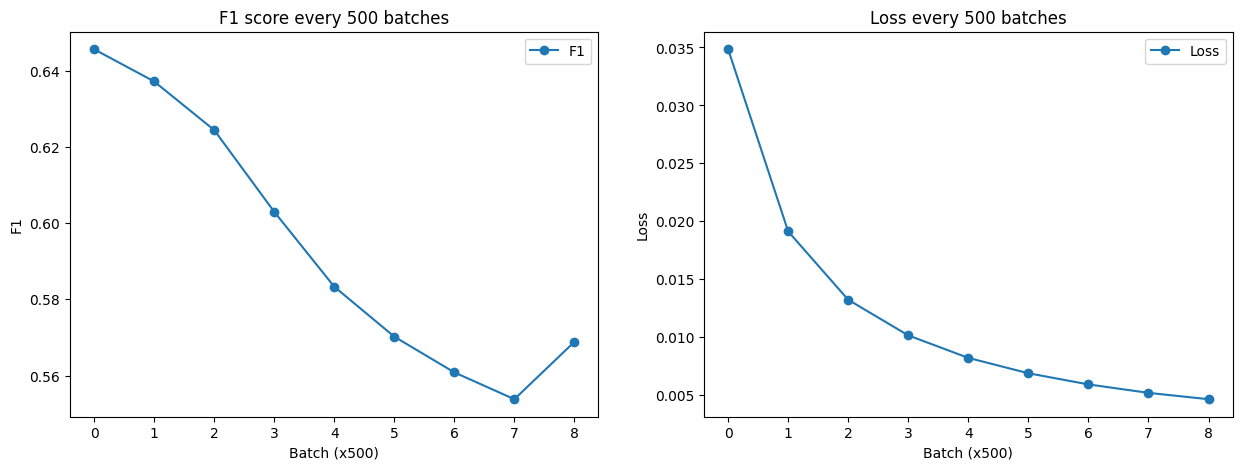

In [1]:

import re
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange, tqdm
from sklearn.metrics import f1_score
from transformers import ElectraTokenizer, ElectraForTokenClassification
from torch import nn, optim
from google.colab import files
from IPython.display import display, clear_output


BATCH_SIZE = 16
SEQ_LEN = 128
VALIDATION_SPLIT = 0.05
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


try:
    with open("train_data.utf8", "r", encoding="utf-8") as f:
        pass
except FileNotFoundError:
    uploaded = files.upload()

filename = list(uploaded.keys())[0]
with open(filename, "r", encoding="utf-8") as f:
    text_data = f.read()


text_data = text_data.replace("\n", " ")
text_data_clean = re.sub(r'[^a-zA-Z0-9.,!?áčďéěíňóřšťúůýžÁČĎÉĚÍŇÓŘŠŤÚŮÝŽ ]', '', text_data)
text_data_clean = re.sub(r'\s+', ' ', text_data_clean).strip()
words = text_data_clean.split(" ")
split_index = round(len(words) * (1 - VALIDATION_SPLIT))
train_data = words[:split_index]


tokenizer = ElectraTokenizer.from_pretrained("Seznam/small-e-czech")


def tokenize_with_labels(data, tokenizer):
    input_ids = []
    label_ids = []

    for word in tqdm(data, desc="Tokenizing"):
        if word == "":
            continue
        label = 1 if word[0].isupper() else 0
        tokens = tokenizer.tokenize(word)
        if not tokens:
            continue
        token_ids = tokenizer.convert_tokens_to_ids(tokens)
        input_ids.extend(token_ids)
        label_ids.append(label)
        label_ids.extend([-100] * (len(token_ids) - 1))  # Mask out sub-tokens

    return input_ids, label_ids

input_ids, label_ids = tokenize_with_labels(train_data, tokenizer)


def batch_generator(inputs, labels, batch_size, seq_len):
    while True:
        for i in range(0, len(inputs) - seq_len * batch_size, batch_size * seq_len):
            batch_inputs, batch_masks, batch_labels = [], [], []
            for j in range(batch_size):
                start = i + j * seq_len
                end = start + seq_len
                batch_inputs.append(inputs[start:end])
                batch_labels.append(labels[start:end])
                batch_masks.append([1] * seq_len)
            yield (
                torch.tensor(batch_inputs).to(device),
                torch.tensor(batch_masks).to(device),
                torch.tensor(batch_labels).to(device),
            )


model = ElectraForTokenClassification.from_pretrained("Seznam/small-e-czech", num_labels=2).to(device)


criterion = nn.CrossEntropyLoss(ignore_index=-100, weight=torch.tensor([1.0, 5.0]).to(device))
optimizer = optim.AdamW(model.parameters(), lr=5e-5)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
loss_vals, f1_vals = [], []
running_loss = 0
running_f1 = 0


train_gen = batch_generator(input_ids, label_ids, BATCH_SIZE, SEQ_LEN)
model.train()
t = trange(50000, desc="Training")

for i in t:
    inputs, masks, labels = next(train_gen)
    optimizer.zero_grad()
    outputs = model(input_ids=inputs, attention_mask=masks)
    logits = outputs.logits.permute(0, 2, 1)
    loss = criterion(logits, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    preds = torch.argmax(logits.detach().cpu(), dim=1).view(-1)
    targets = labels.detach().cpu().view(-1)


    f1 = f1_score(preds, targets, average=None, labels=[1], zero_division=0)
    running_f1 += f1[0]

    t.set_description(f"Loss: {running_loss/(i+1):.4f} | F1: {running_f1/(i+1):.4f}")


    if (i + 1) % 500 == 0:
        loss_vals.append(running_loss / (i + 1))
        f1_vals.append(running_f1 / (i + 1))

        ax1.clear()
        ax2.clear()
        ax1.set_title('F1 score every 500 batches')
        ax1.set_xlabel('Batch (x500)')
        ax1.set_ylabel('F1')
        ax2.set_title('Loss every 500 batches')
        ax2.set_xlabel('Batch (x500)')
        ax2.set_ylabel('Loss')
        ax1.plot(f1_vals, '-o', label='F1')
        ax2.plot(loss_vals, '-o', label='Loss')
        ax1.legend()
        ax2.legend()
        clear_output(wait=True)
        display(fig)


    if (i + 1) % 1000 == 0:
        unique, counts = torch.unique(preds, return_counts=True)
        print("Prediction class distribution:", dict(zip(unique.tolist(), counts.tolist())))
